# 평가 조건
- 평가 문항
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
 - 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
 - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
 - 60% 이상 도달하였음

# 모듈 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

# 데이터 만들기
- https://teachablemachine.withgoogle.com/ 여기에서 무료로 사진 만들수 있음
- 디렉토리 만들기
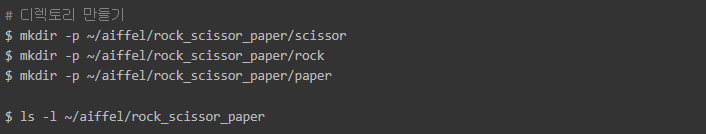
- 사진 압축 해제
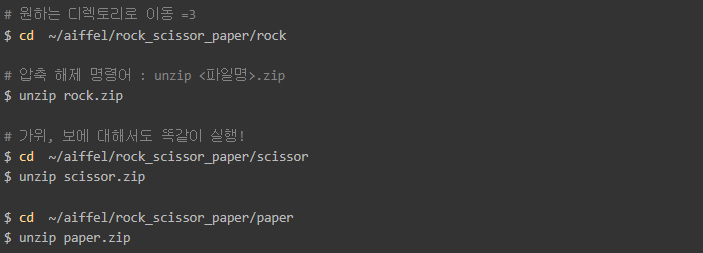

## 사진 28,28로 resize

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

	target_size=(28,28) #파일마다 모두 28x28 사이즈로 바꾸어 저장
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [3]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/lsh"
resize_images(image_dir_path)

print("가위 이미지 resize 완료")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료


In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/lsh"
resize_images(image_dir_path)

print("바위 이미지 resize 완료")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료


In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/lsh"
resize_images(image_dir_path)

print("보 이미지 resize 완료")

100  images to be resized.
100  images resized.
보 이미지 resize 완료


## load_data 함수 만들기

In [6]:
import numpy as np

def load_data(img_path, number_of_data=300):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [7]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 데이터 확인

라벨:  0


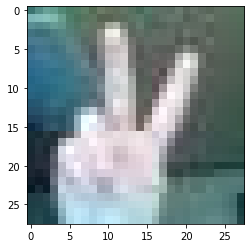

In [8]:
plt.imshow(x_train[1])
print('라벨: ', y_train[1])

# 모델 만들기

In [13]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [14]:
#딥러닝 모델 확인

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

# 학습시키기
- validation_split을 적용해주면 split을 하지 않아도, train데이터에서 20%를 validation set으로 평가해줌

In [15]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_split = 0.2, epochs=10) 
print(history)

Epoch 1/10
8/8 [==============================] - 1s 23ms/step - loss: 20.4881 - accuracy: 0.4417 - val_loss: 56.6182 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 7.0482 - accuracy: 0.4625 - val_loss: 2.7530 - val_accuracy: 0.2833
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0911 - accuracy: 0.7875 - val_loss: 1.9572 - val_accuracy: 0.5000
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5215 - accuracy: 0.8208 - val_loss: 1.2893 - val_accuracy: 0.7333
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3042 - accuracy: 0.9250 - val_loss: 0.2503 - val_accuracy: 0.9000
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.1187 - accuracy: 0.9667 - val_loss: 0.5012 - val_accuracy: 0.8667
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0862 - accuracy: 0.9667 - val_loss: 0.2985 - val_accuracy: 0.9000
Epoch 8/10
8/8 [===========

## 훈련 과정 시각화(accuracy & loss)

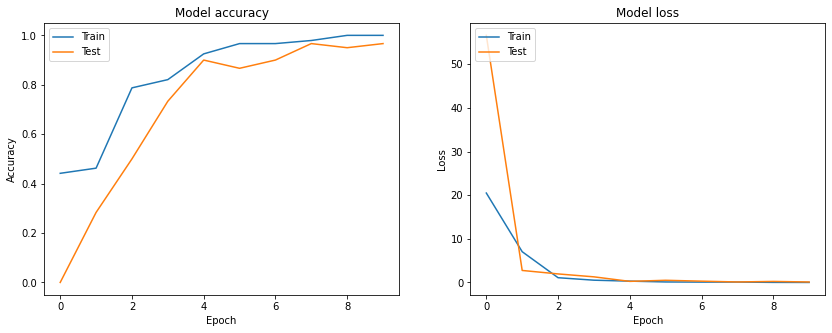

In [20]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

- accuracy가 급격하게 상승하는 것을 보아 오버피팅이 발생한것으로 생각됨
- loss값도 비정상적으로 급격하게 떨어진것을 볼 수 있음

## 평가데이터 셋 만들기
- testset은 같이 교육을 듣는 다른 그루분의 사진으로 test 진행
- trainset과 똑같이 알집 파일을 풀어줘야함
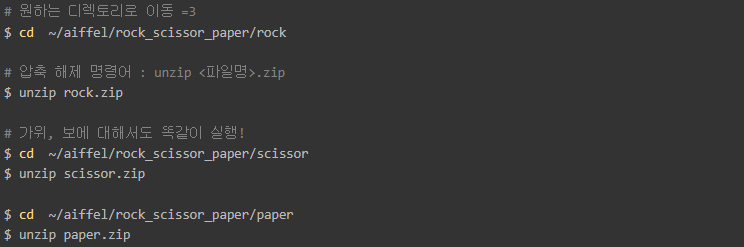

In [21]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("테스트 가위 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 가위 이미지 resize 완료


In [22]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("테스트 바위 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 바위 이미지 resize 완료


In [23]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("테스트 보 이미지 resize 완료")

100  images to be resized.
100  images resized.
테스트 보 이미지 resize 완료


In [24]:
import numpy as np

def test_load_data(img_path, number_of_data=300):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


In [25]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=test_load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


# 모델 평가

In [26]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 6.3460 - accuracy: 0.3333
test_loss: 6.346045017242432
test_accuracy: 0.3333333432674408


- 1차적인 베이스라인는 정확도가 약 0.33정도 나왔음

## 모델 추론값 확인

In [27]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [9.9876010e-01 1.2352295e-08 1.2399018e-03]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


예측확률분포: [9.8840404e-01 4.6218457e-07 1.1595499e-02]
라벨: 2, 예측결과: 0


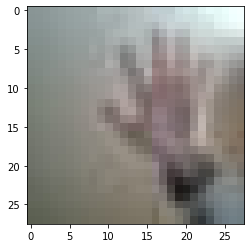

예측확률분포: [8.3203638e-01 3.0328241e-07 1.6796339e-01]
라벨: 2, 예측결과: 0


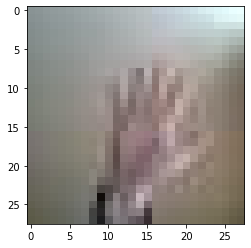

예측확률분포: [9.996501e-01 8.660444e-13 3.498431e-04]
라벨: 2, 예측결과: 0


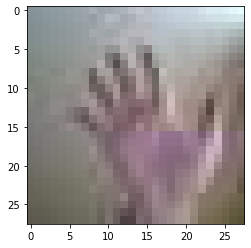

예측확률분포: [7.6558727e-01 6.1029405e-06 2.3440658e-01]
라벨: 1, 예측결과: 0


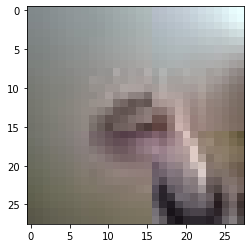

예측확률분포: [9.975533e-01 7.662797e-06 2.439139e-03]
라벨: 1, 예측결과: 0


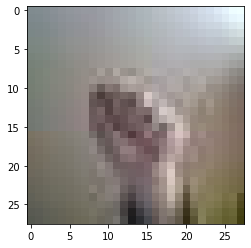

In [28]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()
    
#0: 가위 / 1: 바위 / 2: 보

- 예측 결과를 확인해본 결과, 사진이 흐릿해서 제대로 예측을 못하는 것인지 파악이 안됨
- 또한 300개 데이터를 학습하였는데, 학습 당시의 accuracy와 loss를 보면 오버피팅이 되었음
- 학습 데이터의 수를 사진의 위치를 90도 회전 시키거나, 180도 뒤집는 방법등으로 늘려주는 것도 괜찮을 것이라고 생각되며, 추가적으로 그루분들의 사진도 추가하는것도 방법이 될 수 있음
- 그리고 모델 layer를 더 설계하는 방법도 존재하고, parameter값도 변경해줄 수 있음

## 성능을 향상시킬 수 있는 방법 정리
1. 학습 데이터의 수를 늘린다.
 - 사진을 회전 및 뒤집기, 그루분들의 사진 추가 등
2. 모델 layer를 추가로 구성한다.
3. dropout 등의 방법 사용
4. hyper parameter값들을 수정한다.
5. 여러가지 방법 조합 시도

## 1. 학습 데이터의 수를 늘린다.
 - 사진을 회전 및 뒤집기, 그루 사진 추가
 - https://hipolarbear.tistory.com/19 참고

In [29]:
import re

def Augmentation_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    new_path = img_path
    print(len(images), " images to be resized.")
    
    target_size=(28,28) #파일마다 모두 28x28 사이즈로 바꾸어 저장
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    for img in images: #이미지 좌우 반전
        old_img=Image.open(img)
        LEFT_RIGHT_new_img = old_img.transpose(Image.FLIP_LEFT_RIGHT)
        numbers = re.sub(r'[^0-9]', '', img)
        LEFT_RIGHT_new_img.save(new_path+'/'+numbers+'_LEFT_RIGHT.jpg',"JPEG")
    
    print('이미지 좌우 반전 완료')
    
    for img in images: #이미지 상하 반전
        old_img=Image.open(img)
        TOP_BOTTOM_new_img = old_img.transpose(Image.FLIP_TOP_BOTTOM)
        numbers = re.sub(r'[^0-9]', '', img)
        TOP_BOTTOM_new_img.save(new_path+'/'+numbers+'_TOP_BOTTOM.jpg',"JPEG")

    print('이미지 상하 반전 완료')
    
    new_images=glob.glob(img_path + "/*.jpg")
    print(len(new_images), " images Augmentation.")

In [30]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/lsh"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [31]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/lsh"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [32]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/lsh"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


In [33]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/llsh"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [34]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/llsh"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [35]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/llsh"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


In [36]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor/psw"
Augmentation_images(image_dir_path)

print("가위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
가위 이미지 Augmentation 완료


In [37]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock/psw"
Augmentation_images(image_dir_path)

print("바위 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
바위 이미지 Augmentation 완료


In [38]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper/psw"
Augmentation_images(image_dir_path)

print("보 이미지 Augmentation 완료")

100  images to be resized.
이미지 좌우 반전 완료
이미지 상하 반전 완료
300  images Augmentation.
보 이미지 Augmentation 완료


- 증강된 데이터
- 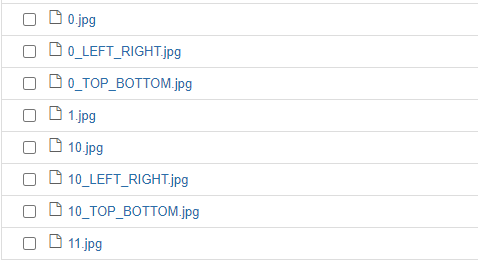

### load_data 함수 만들기

In [39]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/lsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [40]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train1, y_train1)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train1.shape))
print("y_train shape: {}".format(y_train1.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


In [41]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/llsh/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [42]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train2, y_train2)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train2.shape))
print("y_train shape: {}".format(y_train2.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


In [43]:
import numpy as np

def ag_load_data(img_path, number_of_data=900):#사진 총 합 넣기
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/psw/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [44]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train3, y_train3)=ag_load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train3.shape))
print("y_train shape: {}".format(y_train3.shape))

학습데이터(x_train)의 이미지 개수는 900 입니다.
x_train shape: (900, 28, 28, 3)
y_train shape: (900,)


### 데이터 합치기

In [ ]:
ag_x_train = np.concatenate([x_train1, x_train2, x_train3], 0)
ag_y_train = np.concatenate([y_train1, y_train2, y_train3], 0)

In [53]:
print("ag_x_train shape: {}".format(ag_x_train.shape))
print("ag_y_train shape: {}".format(ag_y_train.shape))

ag_x_train shape: (2700, 28, 28, 3)
ag_y_train shape: (2700,)


### 모델 학습

In [77]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [78]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(ag_x_train, ag_y_train, validation_split = 0.25, epochs=10) 
print(history)

Epoch 1/10
64/64 [==============================] - 1s 8ms/step - loss: 4.9627 - accuracy: 0.5472 - val_loss: 8.0591 - val_accuracy: 0.1570
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.8153 - val_loss: 9.5192 - val_accuracy: 0.1230
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.8998 - val_loss: 9.0780 - val_accuracy: 0.1259
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9363 - val_loss: 9.7539 - val_accuracy: 0.1274
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1472 - accuracy: 0.9541 - val_loss: 8.0685 - val_accuracy: 0.1956
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1065 - accuracy: 0.9640 - val_loss: 8.7584 - val_accuracy: 0.1748
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0494 - accuracy: 0.9847 - val_loss: 8.4004 - val_accuracy: 0.1763
Epoch 8/10
64/64 [==

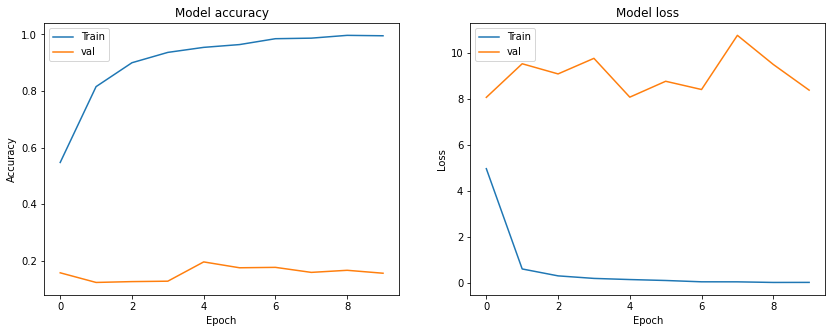

In [79]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'val'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

### 모델 평가

In [80]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.0107 - accuracy: 0.5467
test_loss: 2.0106570720672607
test_accuracy: 0.54666668176651


## 2. 모델 layer를 추가로 구성한다.

In [86]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  9


In [87]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(ag_x_train, ag_y_train, validation_split = 0.25, epochs=10) 
print(history)

Epoch 1/10
64/64 [==============================] - 1s 8ms/step - loss: 2.1524 - accuracy: 0.5896 - val_loss: 3.5589 - val_accuracy: 0.1852
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.4462 - accuracy: 0.8227 - val_loss: 3.5779 - val_accuracy: 0.2400
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.3084 - accuracy: 0.8800 - val_loss: 2.4756 - val_accuracy: 0.3852
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1937 - accuracy: 0.9254 - val_loss: 6.7022 - val_accuracy: 0.1496
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1264 - accuracy: 0.9600 - val_loss: 5.2284 - val_accuracy: 0.2252
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0877 - accuracy: 0.9689 - val_loss: 5.8907 - val_accuracy: 0.2356
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0709 - accuracy: 0.9773 - val_loss: 4.3202 - val_accuracy: 0.2607
Epoch 8/10
64/64 [==

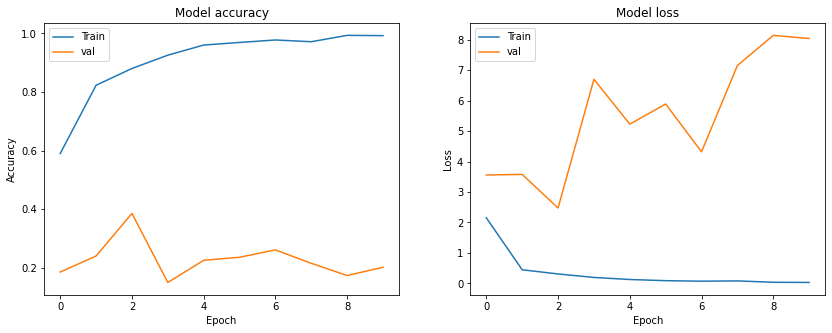

In [88]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'val'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [89]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.8409 - accuracy: 0.7000
test_loss: 0.8409481644630432
test_accuracy: 0.699999988079071


## 3. dropout 등의 방법 사용

In [90]:
from keras.layers import Dropout

np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(Dropout(0.15))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.15))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  9


In [91]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(ag_x_train, ag_y_train, validation_split = 0.25, epochs=10) 
print(history)

Epoch 1/10
64/64 [==============================] - 1s 6ms/step - loss: 6.9319 - accuracy: 0.3911 - val_loss: 1.1041 - val_accuracy: 0.1111
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 1.1037 - accuracy: 0.4074 - val_loss: 1.1158 - val_accuracy: 0.1111
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0952 - accuracy: 0.4064 - val_loss: 1.1272 - val_accuracy: 0.1111
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0898 - accuracy: 0.4079 - val_loss: 1.1369 - val_accuracy: 0.1111
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0875 - accuracy: 0.4089 - val_loss: 1.1451 - val_accuracy: 0.1111
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0890 - accuracy: 0.4099 - val_loss: 1.1522 - val_accuracy: 0.1111
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0868 - accuracy: 0.4084 - val_loss: 1.1577 - val_accuracy: 0.1111
Epoch 8/10
64/64 [==

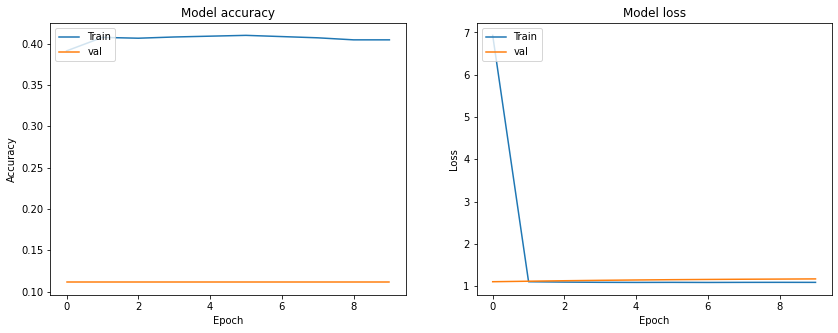

In [92]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'val'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [93]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 1.1078 - accuracy: 0.3333
test_loss: 1.1077579259872437
test_accuracy: 0.3333333432674408


## 4. hyper parameter값들을 수정한다.

In [94]:
np.random.seed(1234)
tf.random.set_seed(1234)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [95]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(ag_x_train, ag_y_train, validation_split = 0.25, epochs=10) 
print(history)

Epoch 1/10
64/64 [==============================] - 1s 8ms/step - loss: 5.4770 - accuracy: 0.6425 - val_loss: 3.7474 - val_accuracy: 0.2089
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.1394 - accuracy: 0.9565 - val_loss: 4.0073 - val_accuracy: 0.2504
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0385 - accuracy: 0.9906 - val_loss: 6.3308 - val_accuracy: 0.1778
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0228 - accuracy: 0.9946 - val_loss: 7.7672 - val_accuracy: 0.1615
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 6.9758 - val_accuracy: 0.2178
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 7.6956 - val_accuracy: 0.1837
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 8.2134 - val_accuracy: 0.1822
Epoch 8/10
64/64 [==

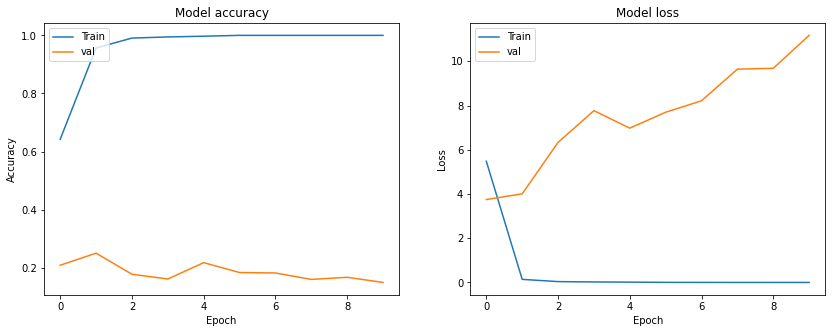

In [96]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'val'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [97]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.9972 - accuracy: 0.6267
test_loss: 0.9972230195999146
test_accuracy: 0.6266666650772095


- 학습데이터 추가와 모델의 layer를 추가하여 루브릭 조건인 accuracy 60%를 넘을 수 있었음
- 추가적으로 위에서 사용한 방법들을 조합하여 시도해보았음

## 5. 여러가지 방법 조합 시도

In [114]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(1,1))
model.add(Dropout(0.3))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((1,1)))
model.add(Dropout(0.3))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  13


In [115]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(ag_x_train, ag_y_train, validation_split = 0.3, epochs=10, batch_size = 32) 
print(history)

Epoch 1/10
60/60 [==============================] - 1s 10ms/step - loss: 33.4143 - accuracy: 0.3923 - val_loss: 1.1438 - val_accuracy: 0.3255
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.8193 - accuracy: 0.5786 - val_loss: 3.0137 - val_accuracy: 0.2750
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6119 - accuracy: 0.7194 - val_loss: 4.6054 - val_accuracy: 0.2824
Epoch 4/10
60/60 [==============================] - 0s 7ms/step - loss: 0.5325 - accuracy: 0.7644 - val_loss: 7.9550 - val_accuracy: 0.2725
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.4355 - accuracy: 0.8184 - val_loss: 7.8455 - val_accuracy: 0.2737
Epoch 6/10
60/60 [==============================] - 0s 7ms/step - loss: 0.4133 - accuracy: 0.8317 - val_loss: 12.6044 - val_accuracy: 0.2750
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 0.3034 - accuracy: 0.8814 - val_loss: 13.5253 - val_accuracy: 0.2713
Epoch 8/10
60/60

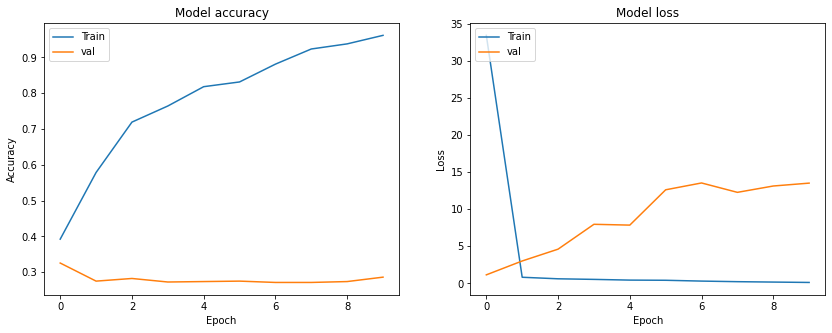

In [116]:
#정확도
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'val'], loc='upper left')

#loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [117]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.5612 - accuracy: 0.8067
test_loss: 0.5612015724182129
test_accuracy: 0.8066666722297668


# 전체 회고
- 케라스 모델을 이용하여 이미지 분류 모델을 만들어보았음
- 학습데이터와 layer를 추가하여 루브릭 조건을 달성할 수 있었지만, 추가적인 방법들을 적용하여 73%의 정확도를 달성하였음
- 이번 exploration은 데이터를 내가 직접 만들었다는 것이 재미가 있었음
- 이미지를 많이 다뤄보지 않았지만, 이미지도 다루다 보니 재미가 있다는 생각이 들었음
- 성능을 올리기 위하여 다양한 방법들을 생각하고 시도하느라 모델과 함수를 수정하는것이 재미있었음
- 시각화를 했을때, 저런 그래프 모양이 나오면 학습이 제대로 되지 않은 것이 아닌가 하는 생각이 듬
- 하지만 test set의 결과는 좋게 나오는게 이상함
- 좀 더 공부가 필요하다고 생각됨
- 데이터를 증강시키는 코드를 효율적으로 만들지 못해서 조금은 아쉬움
- 딥러닝은 학습 데이터가 많은 것이 과적합을 방지할 수 있는 첫번째인것 같고, 추가적으로 dropout 등의 기술도 중요하다고 생각됨
- 이번 exploration을 하면서 이미지 딥러닝에 대해 스스로 찾아보고 공부할 수 있었으며, 모델을 설계하는 방법이나 과적합을 방지하는 방법 등을 아직 완벽하게 이해한것은 아니지만, 공부할 수 있어서 좋았음